In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn
import sklearn.tree
import sklearn.ensemble
import sklearn.metrics
import scipy
import scipy.stats

In [2]:
#Setup data file path(s)
cwd = os.getcwd()
parent_directory = os.path.dirname(cwd)
data_directory = parent_directory + '\\data'
data_paths = [
    data_directory + '\\mr_bike_demand.csv',
    data_directory + '\\mr_dock_demand.csv'
]

In [3]:
station_bike_demand = pd.read_csv(data_paths[0], index_col='start_date', parse_dates=['start_date']).asfreq('D')


In [4]:
# Split station data into training and test set
data_train = station_bike_demand['2014':'2018']
data_test  = station_bike_demand['2019':'2019']

# Add zeros for 2014 before April to have consistent period windows
df = pd.DataFrame(index=pd.date_range(start='2014-01-01', end='2014-04-01', freq='D'), columns=['trip_count'])
df['trip_count'] = 0
data_train = pd.concat([df, data_train])

# Exclude November data from the test set
data_test  = data_test[:'2019-10-31']
display(data_train.head())

,trip_count
2014-01-01,0
2014-01-02,0
2014-01-03,0
2014-01-04,0
2014-01-05,0


In [5]:
#Generate Training Data

#Split dates into day/month/year columns
years = np.array(data_train.index.year)
months = np.array(data_train.index.month)
days = np.array(data_train.index.day)

#Form feature vectors
X_train_raw = np.column_stack((years,months,days))
#Make target vector
y_train_raw = np.array(data_train['trip_count'])

#Verify Training X and y
print(X_train_raw.shape)
print(y_train_raw.shape)

#print(X_train[X_train.shape[0]-5 : X_train.shape[0]])             
#print(y_train[y_train.shape[0]-5 : X_train.shape[0]])

(1813, 3)
(1813,)


In [6]:
#Generate Test Data
test_years = np.array(data_test.index.year)
test_months = np.array(data_test.index.month)
test_days = np.array(data_test.index.day)
#Form feature vectors
X_2019_test = np.column_stack((test_years,test_months,test_days))
#Make target vector
y_2019_test = np.array(data_test['trip_count'])


print(X_2019_test.shape)
print(y_2019_test.shape)

(304, 3)
(304,)


In [12]:
#Define Hyperparameters to search over
np.random.seed(1)
n_trials = 25
num_trees = np.random.randint(1,1001,size = n_trials)
depths = np.random.randint(1,11,size = n_trials)
print("Number of Trees used: ", num_trees)
print("Maximum tree Depths: ", depths)

#Define variables to hold results
MSQ_by_trial = np.zeros(n_trials)
percent_error_by_trial = np.zeros(n_trials)

Number of Trees used:  [ 38 236 909  73 768 906 716 646 848 961 145 130 973 584 750 509 391 282
 179 277 255 358 915 469 908]
Maximum tree Depths:  [ 3  5  8  8 10  2  8  1  7 10 10  8  7 10  2  1  2  9  9  4 10  9  8  4
  7]


In [13]:
#Use time series variant of K-fold cross validation to generate estimates of Test time performance
#Collect Data to later be used to define the final model.

splitter=sklearn.model_selection.TimeSeriesSplit(n_splits = 4)
j=0
for n_trees,depth in zip(num_trees,depths):
    i=0
    #print("Testing model with hyperparams of num_trees:",n_trees, " and max_depth: ", depth)
    print("Testing model {} of {}".format(j+1,n_trials), "num_trees:", n_trees, " and max_depth: ", depth)
    percentage_errors = np.zeros(4)
    MSQs = np.zeros(4)
    for train_index, test_index in splitter.split(X_train_raw):
        #print("TRAIN:", train_index, "\nTEST:", test_index)
        X_train, X_test = X_train_raw[train_index], X_train_raw[test_index]
        y_train, y_test = y_train_raw[train_index], y_train_raw[test_index]
        i+=1
        #Define and Fit our Model.
        model = sklearn.ensemble.RandomForestRegressor(n_estimators= n_trees,
                                                   max_depth = depth, random_state=0)
        model = model.fit(X_train,y_train)
        
        #Make predictions and generate useful metrics
        y_pred = model.predict(X_test)
        msq = sklearn.metrics.mean_squared_error(y_test,y_pred)
        mae = sklearn.metrics.mean_absolute_error(y_test,y_pred)

        #Save metrics in an array for later analysis
        percentage_errors[i-1] = mae/np.mean(y_test)*100
        MSQs[i-1] = msq
        
        #print("For test fold ", i)
        #print("Mean Squared Error: ", msq)
        #print("Mean Absolute Error: ", mae)
        #print("Mean of y_test: ", np.mean(y_test))
        #print("Mean absolute % error: ", (mae/np.mean(y_test)*100),"%")
   
    #print("Average % error across test folds: ", np.mean(percentage_errors))
    #print("Average MSQ across test folds: ", np.mean(MSQs))
    MSQ_by_trial[j] = np.mean(MSQs)
    percent_error_by_trial[j] = np.mean(percentage_errors)
    j+=1


Testing model with hyperparams of num_trees: 38  and max_depth:  3
Testing model 1 of 25
Testing model with hyperparams of num_trees: 236  and max_depth:  5
Testing model 2 of 25
Testing model with hyperparams of num_trees: 909  and max_depth:  8
Testing model 3 of 25
Testing model with hyperparams of num_trees: 73  and max_depth:  8
Testing model 4 of 25
Testing model with hyperparams of num_trees: 768  and max_depth:  10
Testing model 5 of 25
Testing model with hyperparams of num_trees: 906  and max_depth:  2
Testing model 6 of 25
Testing model with hyperparams of num_trees: 716  and max_depth:  8
Testing model 7 of 25
Testing model with hyperparams of num_trees: 646  and max_depth:  1
Testing model 8 of 25
Testing model with hyperparams of num_trees: 848  and max_depth:  7
Testing model 9 of 25
Testing model with hyperparams of num_trees: 961  and max_depth:  10
Testing model 10 of 25
Testing model with hyperparams of num_trees: 145  and max_depth:  10
Testing model 11 of 25
Testing

Best Classifier Attributes: 
Number of Estimators:  236 Max Depth:  5
MSQ of best classifer:  1342.9741496810905


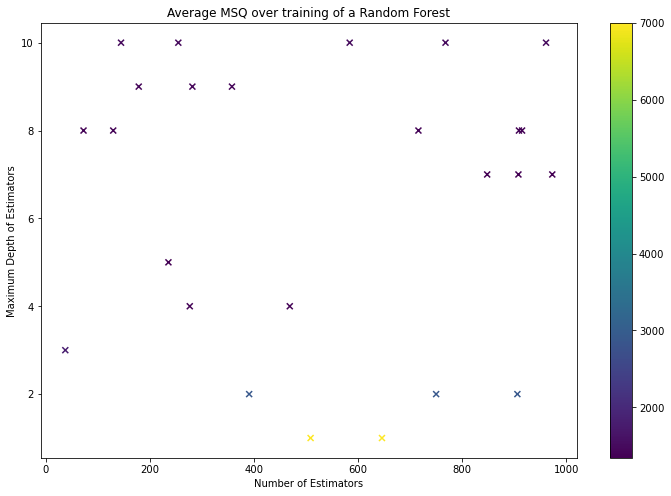

In [15]:
#Code for plotting a summary of hyperparameter effects on MSQ
plt.figure(figsize =(12,8));
plt.scatter(num_trees, depths, marker = 'x', c = MSQ_by_trial)
plt.colorbar()
plt.title("Average MSQ over training of a Random Forest")
plt.xlabel("Number of Estimators")
plt.ylabel("Maximum Depth of Estimators");
#print("Min MSQ: ", np.min(MSQ_by_trial))
#print(np.argmin(MSQ_by_trial))
print("Best Classifier Attributes: ")
print("Number of Estimators: ", num_trees[np.argmin(MSQ_by_trial)], "Max Depth: ", depths[np.argmin(MSQ_by_trial)])
print("MSQ of best classifer: ", np.min(MSQ_by_trial))

In [ ]:
#Final Model Training and Performance


In [ ]:
#Define helper function to split data by year.

def get_data_by_year(year, X_data = X_train_raw, y_data = y_train_raw):
    X = X_data[X_data[:,0] == year]
    y = y_data[0:X.shape[0]]
    return X,y

#X,y = get_data_by_year(2016)
#print(X.shape)
#print(y.shape)

In [ ]:
#Split the data up into testing and training by time.

#Choose n_splits = number of years to split training data by year
splitter=sklearn.model_selection.TimeSeriesSplit(n_splits = 4)
i=1
#Loop over each set of splits then train and test a model.
num_trees = np.array([10,100,500,1000,1500,2000,2500])
depths = np.linspace(1,10,10)
for train_index, test_index in splitter.split(X_train_raw):
    #print("TRAIN:", train_index, "\nTEST:", test_index)
    X_train, X_test = X_train_raw[train_index], X_train_raw[test_index]
    y_train, y_test = y_train_raw[train_index], y_train_raw[test_index]
    
    model = sklearn.ensemble.RandomForestRegressor(n_estimators= 100,
                                                   max_depth = 10, random_state=0)
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    msq = sklearn.metrics.mean_squared_error(y_test,y_pred)
    mae = sklearn.metrics.mean_absolute_error(y_test,y_pred)
    score = model.score(X_test,y_test)
    
    print("\nFor test fold ", i)
    print("Mean Squared Error: ", msq)
    print("Mean Absolute Error: ", mae)
    print("Mean of y_test: ", np.mean(y_test))
    print("Mean absolute % error: ", (mae/np.mean(y_test)*100),"%")
    
    #plt.plot(np.arange(0,y_pred.shape[0]),y_pred, label = "y_pred")
    #plt.plot(np.arange(0,y_test.shape[0]),y_test, label = "y_test")
    #plt.legend()
    #plt.title("Model trained on {}  years".format(i))
   
    #plt.figure()
    i+=1